In [4]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
from matplotlib import rc
from mpl_toolkits.axes_grid1 import make_axes_locatable
import seaborn as sns
import pandas as pd
import json

from scipy.interpolate import griddata
from scipy.ndimage import gaussian_filter

from qibo import models
from qaoa_utils import exprectum_hamiltonian_brute_force, create_random_state, exprectum_hamiltonian, create_gibbs_state, create_gausgibbs_state, expected_value, sample_state, build_maxcut_hamiltonian, build_mixer_hamiltonian, max_cut_brute_force, create_local_state

# **Pseudo-Gibbs, Gibbs and One States**

{-8.0: 2, -7.0: 6, -6.0: 18, -5.0: 20, -4.0: 8, -3.0: 6, -2.0: 2, 0.0: 2}


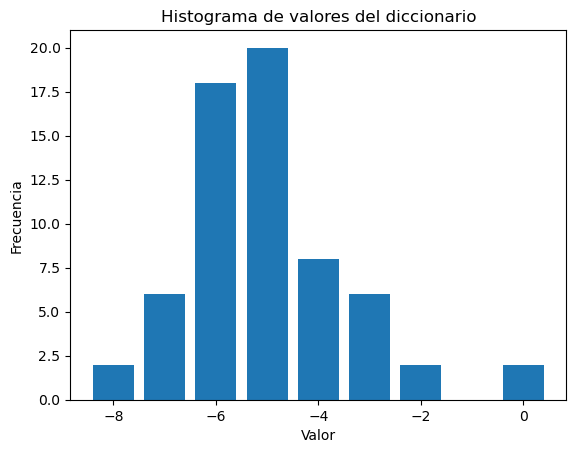

In [5]:
n = 6
p = 0.7

G = nx.erdos_renyi_graph(n, p, seed = 2)

#G = random_uniform_weights(nodes = n)

dict_values = exprectum_hamiltonian_brute_force(G)

# Tu diccionario
mi_diccionario = dict_values

# Obtener los valores del diccionario
valores = list(mi_diccionario.values())

# Contar la frecuencia de cada valor
frecuencia = {}
for valor in valores:
    if valor in frecuencia:
        frecuencia[valor] += 1
    else:
        frecuencia[valor] = 1

# Graficar el histograma
plt.bar(frecuencia.keys(), frecuencia.values())

# Etiquetas y título
plt.xlabel('Valor')
plt.ylabel('Frecuencia')
plt.title('Histograma de valores del diccionario')

# Mostrar la gráfica
#plt.show()
print(frecuencia)

# **Energy Landscape**

In [6]:
n = 8
p = 0.5

G = nx.erdos_renyi_graph(n, p, seed = 1)

dict_values = exprectum_hamiltonian(G)

gibbs_state = create_gibbs_state(dict_values, t = 3)
expected_value_gibbs_state = expected_value(state = gibbs_state, dict_values = dict_values)

pseudo_gibbs_state = create_gausgibbs_state(solutions_dict = dict_values, 
                                            delta_energy = 0.6, 
                                            mu_energy = expected_value_gibbs_state)

expected_value_psgibbs_state = expected_value(state=pseudo_gibbs_state, dict_values=dict_values)

dict_pb_gibbs = sample_state(gibbs_state)

pb_gibbs = list(dict_pb_gibbs.values())

entropy_gibbs = -sum(
pb_gibbs[i] * np.log2(pb_gibbs[i])
for i in range(len(pb_gibbs))
if pb_gibbs[i] != 0 )

dict_pb_psgibbs = sample_state(pseudo_gibbs_state)

pb_psgibbs = list(dict_pb_psgibbs.values())

entropy_psgibbs = -sum(
    pb_psgibbs[i] * np.log2(pb_psgibbs[i])
    for i in range(len(pb_psgibbs))
    if pb_psgibbs[i] != 0
        )

hamiltonian = build_maxcut_hamiltonian(graph = G)

mixer_hamiltonian = build_mixer_hamiltonian(graph = G)

print('Energy Gibbs:', expected_value_gibbs_state, 'Entropy Gibbs:', entropy_gibbs)
print('Energy PsGibbs:', expected_value_psgibbs_state, 'Entropy PsGibbs:', entropy_psgibbs)


alpha = np.linspace(-2 * np.pi, 2 * np.pi, 100)
beta = np.linspace(-2 * np.pi, 2 * np.pi, 100)

energy_psgibbs_dict_mc = {}

for a in alpha:
    for b in beta:
        
        final_parameters = np.array([a, b])
        
        qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)
        
        qaoa.set_parameters(final_parameters)
        
        quantum_state = qaoa.execute(initial_state = pseudo_gibbs_state)
        
        value = expected_value(state = quantum_state, dict_values = dict_values)
        
        energy_psgibbs_dict_mc[(a, b)] = value
        
energy_gibbs_dict_mc = {}

for a in alpha:
    for b in beta:
        
        final_parameters = np.array([a, b])
        
        qaoa = models.QAOA(hamiltonian=hamiltonian, mixer=mixer_hamiltonian)
        
        qaoa.set_parameters(final_parameters)
        
        quantum_state = qaoa.execute(initial_state = gibbs_state)
        
        value = expected_value(state = quantum_state, dict_values = dict_values)
        
        energy_gibbs_dict_mc[(a, b)] = value

[Qibo 0.2.8|INFO|2024-09-10 16:30:11]: Using qibojit (numba) backend on /CPU:0


Energy Gibbs: -10.376830408554198 Entropy Gibbs: 7.206914416239607
Energy PsGibbs: -10.19806467041145 Entropy PsGibbs: 6.017836234537546


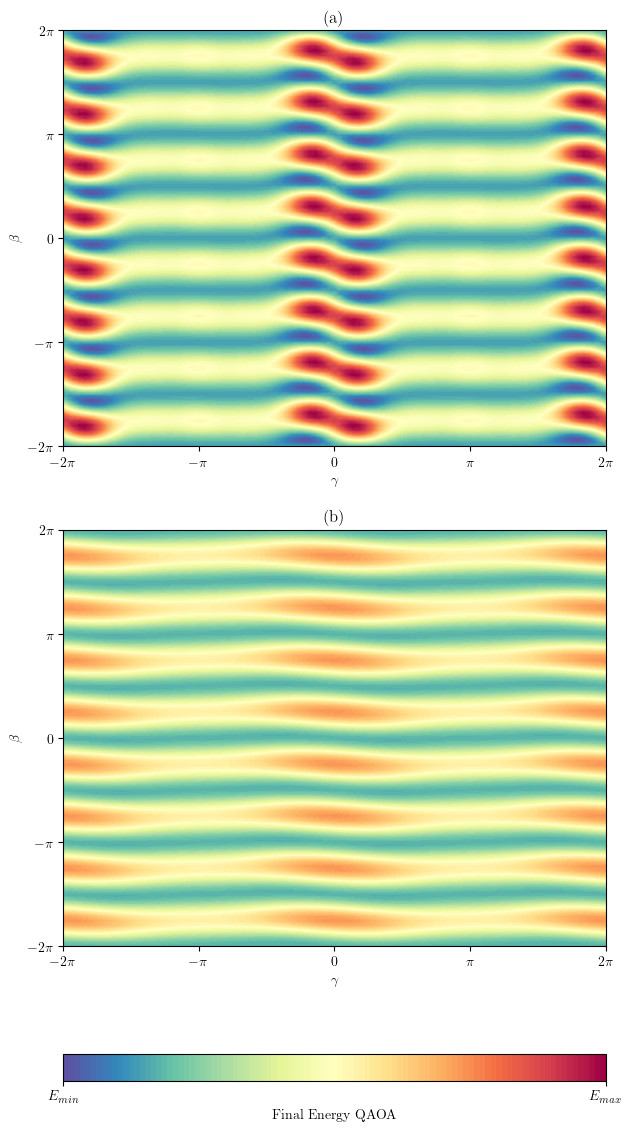

In [7]:
# Configuración de estilo
rc('text', usetex=True)
rc('font', family='serif')

x_gibbs, y_gibbs = zip(*energy_gibbs_dict_mc.keys())
z_gibbs = np.array(list(energy_gibbs_dict_mc.values()))  # Convertir a array de numpy para compatibilidad

x_psgibbs, y_psgibbs = zip(*energy_psgibbs_dict_mc.keys())
z_psgibbs = np.array(list(energy_psgibbs_dict_mc.values()))  # Convertir a array de numpy para compatibilidad

# Convertir a arrays de numpy
x_gibbs = np.array(x_gibbs)
y_gibbs = np.array(y_gibbs)
z_gibbs = np.array(z_gibbs)

x_psgibbs = np.array(x_psgibbs)
y_psgibbs = np.array(y_psgibbs)
z_psgibbs = np.array(z_psgibbs)

# Definir el colormap
cmap = sns.color_palette("Spectral", as_cmap=True, n_colors=100)
cmap = cmap.reversed()

# Crear la figura y los subplots
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(7, 14))  # Cambiado a 2 filas y 1 columna

# Encontrar el rango de valores para la colorbar
z_min = min(z_gibbs.min(), z_psgibbs.min())
z_max = max(z_gibbs.max(), z_psgibbs.max())

# Graficar el primer conjunto de datos
sc1 = ax1.tricontourf(x_gibbs, y_gibbs, z_gibbs, cmap=cmap, levels=np.linspace(z_min, z_max, 100))
ax1.set_xlabel(r"$\gamma$")
ax1.set_ylabel(r"$\beta$")
ax1.set_title("(a)")

# Configurar los ticks de los ejes x e y para que muestren fracciones de pi
pi_ticks = [-2 * np.pi, -np.pi, 0, np.pi, 2 * np.pi]
pi_labels = [r'$-2\pi$', r'$-\pi$', r'$0$', r'$\pi$', r'$2\pi$']
ax1.set_xticks(pi_ticks)
ax1.set_xticklabels(pi_labels)
ax1.set_yticks(pi_ticks)
ax1.set_yticklabels(pi_labels)

# Graficar el segundo conjunto de datos
sc2 = ax2.tricontourf(x_psgibbs, y_psgibbs, z_psgibbs, cmap=cmap, levels=np.linspace(z_min, z_max, 100))
ax2.set_xlabel(r"$\gamma$")
ax2.set_ylabel(r"$\beta$")
ax2.set_title("(b)")

# Configurar los ticks de los ejes x e y para que muestren fracciones de pi
ax2.set_xticks(pi_ticks)
ax2.set_xticklabels(pi_labels)
ax2.set_yticks(pi_ticks)
ax2.set_yticklabels(pi_labels)

# Añadir la barra de color horizontal en la parte inferior
cbar = fig.colorbar(sc1, ax=[ax1, ax2], orientation='horizontal', fraction=0.05, pad=0.1, aspect=20)
cbar.set_label(r'Final Energy QAOA')

# Configurar los ticks personalizados
cbar.set_ticks([z_min, z_max])
cbar.set_ticklabels([r'$E_{min}$', r'$E_{max}$'])

plt.show()


# **Tests Gibbs vs One State**

In [8]:
nodes_list = [8, 10, 12, 14, 16]
temperatures = [3, 4]
layers_list = [3, 5]

results = []

for temperature in temperatures:
    for layer in layers_list:
        for j in nodes_list:
            list_energy_qaoa_difference = []

            for i in range(30):
                # Construcción del nombre del archivo
                path_data_qaoa = (
                    f"logger_data/logger_data_qaoa_performance_gibbs_states_borders_one_state/"
                    f"logger_data_max_cut_qaoa_common_instances_n_{j}_borders/"
                    f"cmaes_qaoa_max_cut_n_{j}_t_{temperature}_layers_{layer}_case_{i}.json"
                )

                try:
                    with open(path_data_qaoa) as f:
                        data = json.load(f)
                except FileNotFoundError:
                    print(f"File not found: {path_data_qaoa}")
                    continue

                # Extracción y cálculo de valores
                energy_qaoa_gibbs_state = data['energy_qaoa_gibbs_state']
                energy_qaoa_one_state = data['energy_qaoa_one_state']
                energy_value_exact = data['energy_value_exact']
                
                relative_energy_qaoa_gibbs_state = (abs(energy_value_exact) - abs(energy_qaoa_gibbs_state)) / abs(energy_value_exact)
                relative_energy_qaoa_one_state = (abs(energy_value_exact) - abs(energy_qaoa_one_state)) / abs(energy_value_exact)
                        
                difference = relative_energy_qaoa_one_state - relative_energy_qaoa_gibbs_state
                list_energy_qaoa_difference.append(difference * 100)

            # Almacenar los resultados para la combinación actual de nodos, temperatura y capas
            results.extend([{
                'energy_qaoa_difference': diff,
                'layers': layer,
                'temperature': temperature,
                'nodes': j
            } for diff in list_energy_qaoa_difference])

# Crear el DataFrame
df_one_state = pd.DataFrame(results)


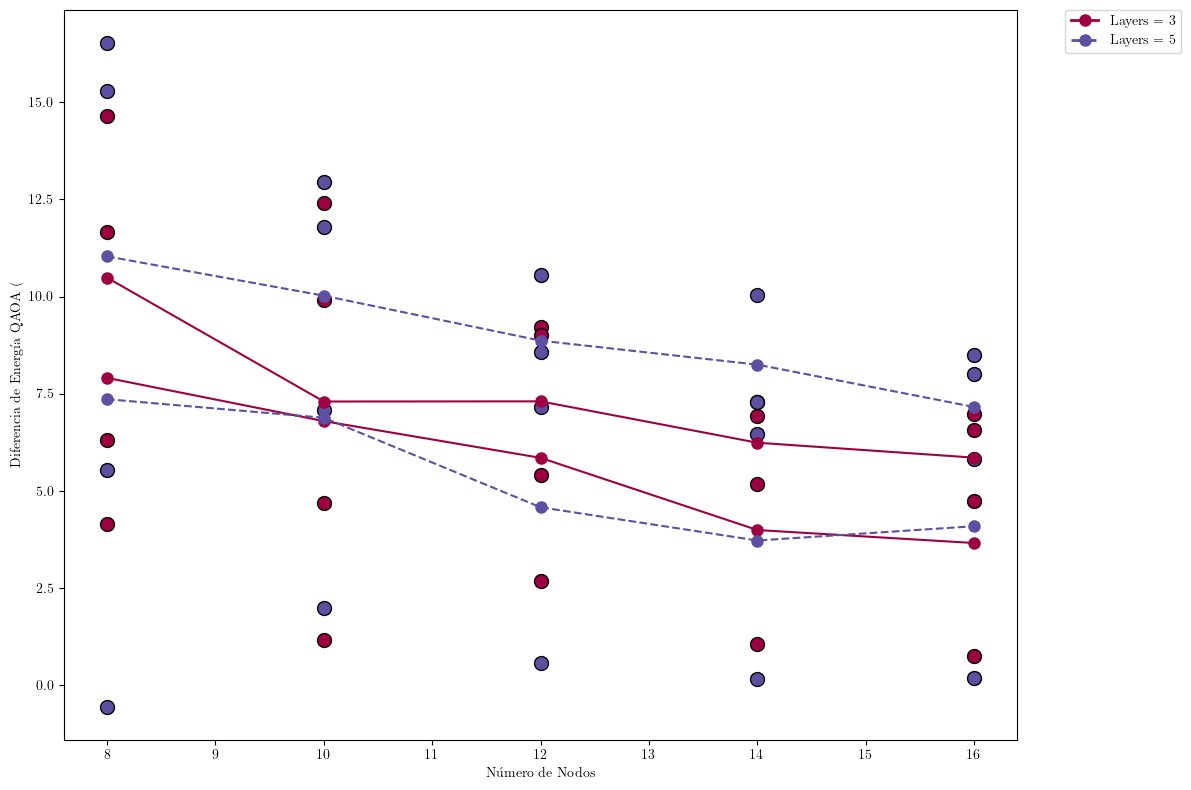

In [9]:
# Calcular la media y desviación estándar
summary_df = df_one_state.groupby(['nodes', 'temperature', 'layers']).agg(
    mean_energy_qaoa_difference=('energy_qaoa_difference', 'mean'),
    std_energy_qaoa_difference=('energy_qaoa_difference', 'std')
).reset_index()

# Define la paleta de colores usando la paleta Spectral
spectral = plt.get_cmap('Spectral')
# Elegir dos colores que se diferencian más (extremos de la paleta)
color_map = {
    3: spectral(0),   # Color del extremo inferior de la paleta
    5: spectral(1000)    # Color del extremo superior de la paleta
}

# Define los estilos de línea para layers
line_styles = {
    3: '-',   # Línea sólida para 3 layers
    5: '--',  # Línea punteada para 5 layers
}

# Define los marcadores para layers
markers = {
    3: 'o',   # Triángulo hacia arriba para 3 layers
    5: 'o',   # Cuadrado para 5 layers
}

# Configura el tamaño de la figura
plt.figure(figsize=(12, 8))

# Graficar los datos
for (temperature, layer) in summary_df[['temperature', 'layers']].drop_duplicates().values:
    subset = summary_df[(summary_df['temperature'] == temperature) & (summary_df['layers'] == layer)]
    
    # Ordenar el subset por nodos para asegurarse de que las líneas se dibujen correctamente
    subset = subset.sort_values(by='nodes')
    
    # Determinar el marcador y color para los puntos de datos
    marker = markers.get(layer, 'o')  # Usar 'o' como marcador por defecto
    color = color_map.get(layer, 'k')  # Color basado en layers
    
    # Graficar la línea con puntos conectados
    plt.plot(
        subset['nodes'],
        subset['mean_energy_qaoa_difference'],
        color=color,  # Color basado en layers
        linestyle=line_styles.get(layer, '-'),  # Estilo de línea basado en layers
        marker=marker,  # Marcador adecuado para layers
        markersize=8,  # Tamaño del marcador
        label=f'Layers = {layer}'  # Etiqueta basada en layers
    )
    
    # Graficar puntos en los extremos de las barras de error (círculos)
    plt.scatter(
        subset['nodes'],
        subset['mean_energy_qaoa_difference'] + subset['std_energy_qaoa_difference'],
        color=color,  # Color basado en layers
        marker='o',  # Usar círculo para los puntos de error
        edgecolor='black',  # Borde del marcador en negro
        s=100,  # Tamaño del marcador
        label='_nolegend_'  # Evitar duplicar leyenda para los marcadores de error
    )
    
    plt.scatter(
        subset['nodes'],
        subset['mean_energy_qaoa_difference'] - subset['std_energy_qaoa_difference'],
        color=color,  # Color basado en layers
        marker='o',  # Usar círculo para los puntos de error
        edgecolor='black',  # Borde del marcador en negro
        s=100,  # Tamaño del marcador
        label='_nolegend_'  # Evitar duplicar leyenda para los marcadores de error
    )

# Crear leyenda personalizada
# Leyenda para estilos de línea (capas)
line_legend_elements = [Line2D([0], [0], color=color_map[layer], linestyle=line_styles.get(layer, '-'), linewidth=2, marker=markers.get(layer, 'o'), markersize=8, label=f'Layers = {layer}') for layer in sorted(summary_df['layers'].unique())]

# Mostrar la leyenda combinada
plt.legend(handles=line_legend_elements,
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           borderaxespad=0.)

# Configura etiquetas y título
plt.xlabel('Número de Nodos')
plt.ylabel('Diferencia de Energía QAOA (%)')
plt.tight_layout()

# Muestra el gráfico
plt.show()

# **Tests Gibbs vs Hadamard State**

**Hadamard vs Gibbs with T fixed**

In [10]:
nodes_list = [6, 8, 10, 12, 14, 16]
temperatures = [0.5, 2, 4, 6]  
layers_list = [5]      

results = []

for temperature in temperatures:
    for layer in layers_list:
        for j in nodes_list:
            list_energy_qaoa_difference = []

            for i in range(30):
                # Construcción del nombre del archivo
                path_data_qaoa = (
                    f"logger_data/logger_data_qaoa_performance_gibbs_states_borders_hadamard_state/"
                    f"logger_data_max_cut_qaoa_common_instances_n_{j}_borders/"
                    f"cmaes_qaoa_max_cut_n_{j}_t_{temperature}_layers_{layer}_case_{i}.json"
                )

                try:
                    with open(path_data_qaoa) as f:
                        data = json.load(f)
                except FileNotFoundError:
                    print(f"File not found: {path_data_qaoa}")
                    continue

                # Extracción y cálculo de valores
                energy_qaoa_gibbs_state = data['energy_qaoa_gibbs_state']
                energy_qaoa_one_state = data['energy_qaoa_hadamard_state']
                energy_value_exact = data['energy_value_exact']
                
                relative_energy_qaoa_gibbs_state = (abs(energy_value_exact) - abs(energy_qaoa_gibbs_state)) / abs(energy_value_exact)
                relative_energy_qaoa_one_state = (abs(energy_value_exact) - abs(energy_qaoa_one_state)) / abs(energy_value_exact)
                        
                difference = relative_energy_qaoa_one_state - relative_energy_qaoa_gibbs_state
                list_energy_qaoa_difference.append(difference * 100)

            # Almacenar los resultados para la combinación actual de nodos, temperatura y capas
            results.extend([{
                'energy_qaoa_difference': diff,
                'layers': layer,
                'temperature': temperature,
                'nodes': j
            } for diff in list_energy_qaoa_difference])

# Crear el DataFrame
df = pd.DataFrame(results)

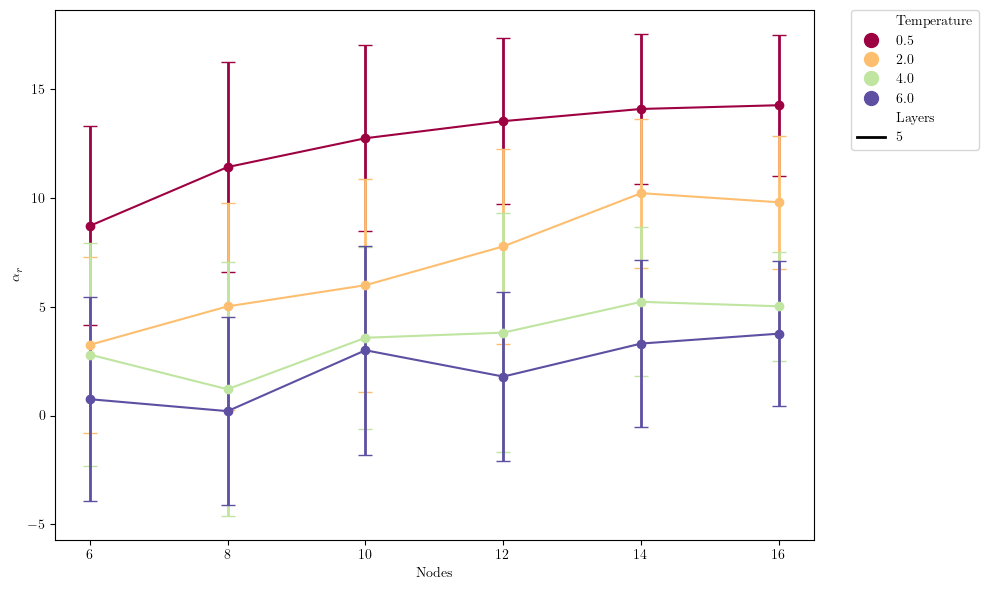

In [11]:
# Calcular la media y desviación estándar
summary_df = df.groupby(['nodes', 'temperature', 'layers']).agg(
    mean_energy_qaoa_difference=('energy_qaoa_difference', 'mean'),
    std_energy_qaoa_difference=('energy_qaoa_difference', 'std')
).reset_index()

# Define la paleta de colores usando la paleta Spectral
spectral = plt.get_cmap('Spectral', len(summary_df['temperature'].unique()))
color_map = {temp: spectral(i / (len(summary_df['temperature'].unique()) - 1)) for i, temp in enumerate(sorted(summary_df['temperature'].unique()))}

# Define los estilos de línea para layers
line_styles = {
    1: '-',   # Línea sólida para 1 layer
    2: '--',  # Línea punteada para 2 layers
    3: '-.',  # Línea punto y guion para 3 layers
    4: ':',   # Línea punteada para 4 layers
}

# Configura el tamaño de la figura
plt.figure(figsize=(10, 6))

# Listas para las leyendas
line_legend_elements = []
color_legend_elements = []

# Graficar los datos
for (temp, layer) in summary_df[['temperature', 'layers']].drop_duplicates().values:
    subset = summary_df[(summary_df['temperature'] == temp) & (summary_df['layers'] == layer)]
    
    # Usar un estilo de línea predeterminado si el layer no está en los definidos
    linestyle = line_styles.get(layer, '-')  # Usar '-' como estilo por defecto
    
    # Agregar elementos a la leyenda de líneas
    if linestyle not in [line.get_linestyle() for line in line_legend_elements]:
        line_element = plt.Line2D([0], [0], color='black', linestyle=linestyle, linewidth=2, label=f'Layers {layer:.1f}')
        line_legend_elements.append(line_element)
    
    # Graficar la línea con barras de error
    
    plt.errorbar(
        subset['nodes'],
        subset['mean_energy_qaoa_difference'],
        yerr=subset['std_energy_qaoa_difference'],  # Barras de error
        color=color_map[temp],  # Color basado en temperatura
        linestyle=linestyle,  # Estilo de línea basado en layers
        marker='o',  # Agregar marcadores en los puntos de datos
        capsize=5,  # Tamaño de las tapas de las barras de error
        elinewidth=2,  # Grosor de las líneas de las barras de error
        label=f'Temperature {temp:.1f}'  # Etiqueta con temperatura redondeada a un decimal
    )
    
# Obtener los elementos de leyenda
handles, labels = plt.gca().get_legend_handles_labels()
temp_labels = {label: handle for handle, label in zip(handles, labels) if 'Temperature' in label}
color_legend_elements = list(temp_labels.values())
color_legend_labels = [label for label in temp_labels.keys()]

# Crear leyenda para temperaturas
color_legend = Line2D([0], [0], color='black', linestyle='None', label='Temperature')
color_legend_elements = [Line2D([0], [0], color=color_map[temp], marker='o', linestyle='None', markersize=10, label=f'{temp:.1f}') for temp in sorted(summary_df['temperature'].unique())]

# Crear leyenda para layers
line_legend = Line2D([0], [0], color='black', linestyle='None', label='Layers')
unique_layers = sorted(set(summary_df['layers']))
line_legend_elements = [Line2D([0], [0], color='black', linestyle=line_styles.get(layer, '-'), linewidth=2, label=f'{layer:.0f}') for layer in unique_layers]

# Mostrar la leyenda combinada
plt.legend(handles=[color_legend] + color_legend_elements + [line_legend] + line_legend_elements,
           bbox_to_anchor=(1.05, 1),
           loc='upper left',
           borderaxespad=0.)

# Configura etiquetas y título
plt.xlabel('Nodes')
plt.ylabel(r'$\alpha_{r}$')

plt.tight_layout()

# Muestra el gráfico
plt.show()


**Hadamard vs Gibbs with N nodes fixed**

In [12]:
# Listas de parámetros
nodes_list = [8, 12, 14, 16]  # Diferentes números de nodos
temperatures = [0.5, 1, 2, 3, 4, 5, 6]
layers_list = [5]

# Lista para almacenar resultados
results = []

# Iterar sobre cada número de nodos, temperatura y capas
for nodes in nodes_list:
    for t in temperatures:
        for layers in layers_list:
            list_energy_qaoa_difference_layers_t = []
            
            # Iterar 30 veces para cada caso
            for i in range(30):
                path_data_qaoa = f"logger_data/logger_data_qaoa_performance_gibbs_states_borders_hadamard_state/logger_data_max_cut_qaoa_common_instances_n_{nodes}_borders/cmaes_qaoa_max_cut_n_{nodes}_t_{t}_layers_{layers}_case_{i}.json"
                
                try:
                    with open(path_data_qaoa) as f:
                        data = json.load(f)
                except FileNotFoundError:
                    print(f"File not found: {path_data_qaoa}")
                    continue
                
                # Extracción y cálculo de valores
                energy_qaoa_gibbs_state = data['energy_qaoa_gibbs_state']
                energy_qaoa_one_state = data['energy_qaoa_hadamard_state']
                energy_value_exact = data['energy_value_exact']
                
                relative_energy_qaoa_gibbs_state = (abs(energy_value_exact) - abs(energy_qaoa_gibbs_state)) / abs(energy_value_exact)
                relative_energy_qaoa_one_state = (abs(energy_value_exact) - abs(energy_qaoa_one_state)) / abs(energy_value_exact)
                
                difference = relative_energy_qaoa_one_state - relative_energy_qaoa_gibbs_state
                list_energy_qaoa_difference_layers_t.append(difference * 100)
            
            # Almacenar los resultados para la combinación actual de nodos, temperatura y capas
            results.extend([{
                'energy_qaoa_difference': diff,
                'layers': layers,
                'temperature': t,
                'nodes': nodes
            } for diff in list_energy_qaoa_difference_layers_t])

# Crear el DataFrame
df_hadamard = pd.DataFrame(results)


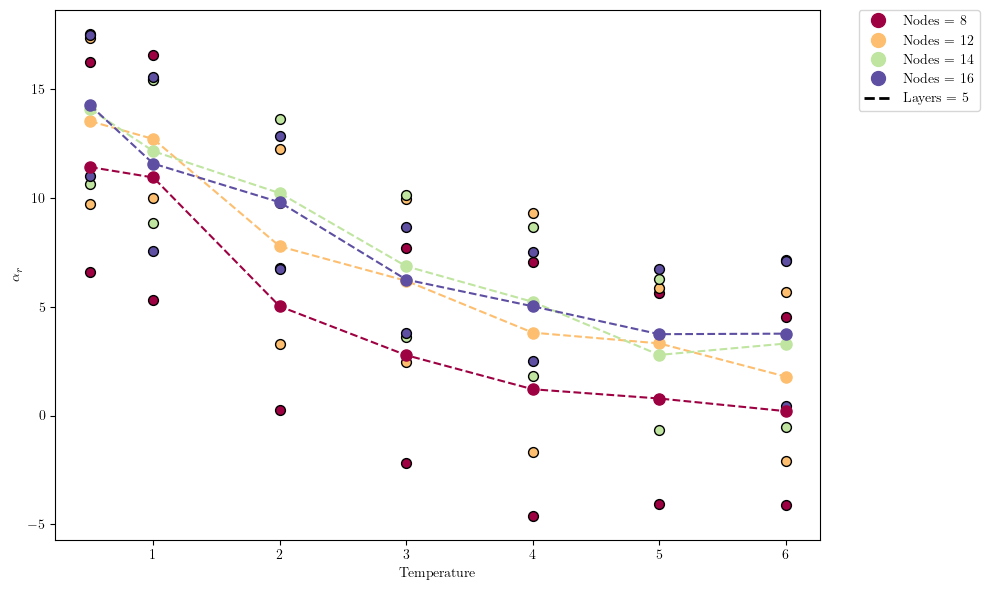

In [13]:
# Calcular la media y desviación estándar
summary_df = (
    df_hadamard.groupby(["nodes", "temperature", "layers"])
    .agg(
        mean_energy_qaoa_difference=("energy_qaoa_difference", "mean"),
        std_energy_qaoa_difference=("energy_qaoa_difference", "std"),
    )
    .reset_index()
)

# Define la paleta de colores usando la paleta Spectral
spectral = plt.get_cmap("Spectral", len(summary_df["nodes"].unique()))
color_map = {
    node: spectral(i / (len(summary_df["nodes"].unique()) - 1))
    for i, node in enumerate(sorted(summary_df["nodes"].unique()))
}

# Define los estilos de línea para layers
line_styles = {
    3: "-",  # Línea sólida para 3 layers
    5: "--",  # Línea punteada para 5 layers
}

# Define los marcadores para layers
markers = {
    3: "^",  # Triángulo hacia arriba para 3 layers
    5: "o",  # Cuadrado para 5 layers
}

# Configura el tamaño de la figura
plt.figure(figsize=(10, 6))

# Graficar los datos
for node, layer in summary_df[["nodes", "layers"]].drop_duplicates().values:

    subset = summary_df[(summary_df["nodes"] == node) & (summary_df["layers"] == layer)]

    # Ordenar el subset por temperatura para asegurarse de que las líneas se dibujen correctamente
    subset = subset.sort_values(by="temperature")

    # Determinar el marcador para los puntos de datos
    marker = markers.get(layer, "o")  # Usar 'o' como marcador por defecto

    # Graficar la línea con puntos conectados
    plt.plot(
        subset["temperature"],
        subset["mean_energy_qaoa_difference"],
        color=color_map[node],  # Color basado en nodes
        linestyle=line_styles.get(layer, "-"),  # Estilo de línea basado en layers
        marker=marker,  # Marcador adecuado para layers
        markersize=8,  # Tamaño del marcador
        label=f"Nodes = {node}, Layers = {layer}",  # Etiqueta combinada para nodos y capas
    )

    # Graficar triángulos/cuadrados en los extremos de las barras de error
    plt.scatter(
        subset["temperature"],
        subset["mean_energy_qaoa_difference"] + subset["std_energy_qaoa_difference"],
        color=color_map[node],  # Color basado en nodes
        marker=marker,  # Marcador adecuado para layers
        edgecolor="black",  # Borde del marcador en negro
        s=50,  # Tamaño del marcador
        label="_nolegend_",  # Evitar duplicar leyenda para los marcadores de error
    )

    plt.scatter(
        subset["temperature"],
        subset["mean_energy_qaoa_difference"] - subset["std_energy_qaoa_difference"],
        color=color_map[node],  # Color basado en nodes
        marker=marker,  # Marcador adecuado para layers
        edgecolor="black",  # Borde del marcador en negro
        s=50,  # Tamaño del marcador
        label="_nolegend_",  # Evitar duplicar leyenda para los marcadores de error
    )

# Crear leyenda personalizada
# Leyenda para colores (nodos)
color_legend_elements = [
    Line2D([0], [0], color=color_map[node], marker="o", linestyle="None", markersize=10, label=f"Nodes = {node}")
    for node in sorted(summary_df["nodes"].unique())
]

# Leyenda para estilos de línea (capas)
line_legend_elements = [
    Line2D([0], [0], color="black", linestyle=line_styles.get(layer, "-"), linewidth=2, label=f"Layers = {layer}")
    for layer in sorted(summary_df["layers"].unique())
]

# Mostrar la leyenda combinada
plt.legend(
    handles=color_legend_elements + line_legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0
)

# Configura etiquetas y título
plt.xlabel("Temperature")
plt.ylabel(r"$\alpha_{r}$")

plt.tight_layout()

# Muestra el gráfico
plt.show()

# **Tests Gibbs vs Pseduo Gibbs**

In [14]:
# Diferentes números de nodos, temperaturas y capas
nodes_list = [8, 12, 14, 16]
temperatures = [0.3, 0.5, 0.7, 0.9]
layers_list = [5]  # Diferentes números de capas
num_cases = 9  # Número de casos

# Lista para almacenar resultados
results = []

# Iterar sobre cada número de nodos, temperatura y capas
for nodes in nodes_list:
    for temp in temperatures:
        for layers in layers_list:
            list_entropy_gibbs_state = []
            list_entropy_pseudo_gibbs_state = []
            list_energy_qaoa_gibbs_state = []
            list_energy_qaoa_pseudo_gibbs_state = []
            
            # Iterar sobre cada caso
            for case_id in range(num_cases):
                path_data_qaoa = f"logger_data/logger_data_qaoa_performance_gibbs_states_temperature/logger_data_max_cut_qaoa_common_instances_n_{nodes}_temperature/cmaes_qaoa_max_cut_n_{nodes}_case_{case_id}_t_4_layers_{layers}_delta_gauss_{temp}.json"
                
                try:
                    with open(path_data_qaoa) as f:
                        data = json.load(f)
                except FileNotFoundError:
                    print(f"File not found: {path_data_qaoa}")
                    continue
                
                # Extracción y cálculo de valores
                entropy_gibbs = data['entropy_gibbs_state']
                entropy_psgibbs = data['entropy_psgibbs_state']
                energy_qaoa_gibbs = data['energy_qaoa_gibbs_state']
                energy_qaoa_psgibbs = data['energy_qaoa_psgibbs_state']
                exact_energy = data['energy_value_exact']
                
                list_entropy_pseudo_gibbs_state.append(abs(entropy_psgibbs) / entropy_gibbs)
                list_entropy_gibbs_state.append(entropy_gibbs / entropy_gibbs)
                list_energy_qaoa_gibbs_state.append((abs(exact_energy) - abs(energy_qaoa_gibbs)) / abs(exact_energy))
                list_energy_qaoa_pseudo_gibbs_state.append((abs(exact_energy) - abs(energy_qaoa_psgibbs)) / abs(exact_energy))
            
            # Almacenar los resultados para la combinación actual de nodos, temperatura y capas
            results.append({
                'nodes': nodes,
                'temperature': temp,
                'layers': layers,
                'entropy_gibbs_state': np.mean(list_entropy_gibbs_state),  # Puedes usar media o cualquier otra métrica
                'entropy_pseudo_gibbs_state': np.mean(list_entropy_pseudo_gibbs_state),  # Puedes usar media o cualquier otra métrica
                'energy_qaoa_gibbs_state': np.mean(list_energy_qaoa_gibbs_state),  # Puedes usar media o cualquier otra métrica
                'energy_qaoa_pseudo_gibbs_state': np.mean(list_energy_qaoa_pseudo_gibbs_state)  # Puedes usar media o cualquier otra métrica
            })

# Convertir resultados en DataFrame
df_results = pd.DataFrame(results)


File not found: logger_data/logger_data_qaoa_performance_gibbs_states_temperature/logger_data_max_cut_qaoa_common_instances_n_14_temperature/cmaes_qaoa_max_cut_n_14_case_1_t_4_layers_5_delta_gauss_0.9.json


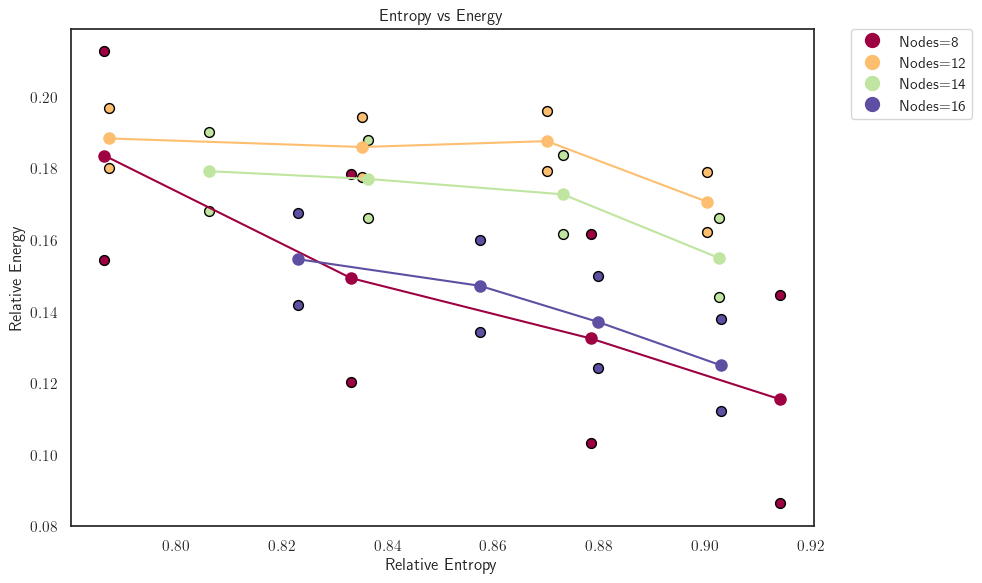

In [15]:
# Configurar estilo de seaborn sin grid
sns.set(style="white")

# Definir la paleta de colores usando Spectral
nodes_list = sorted(df_results['nodes'].unique())
spectral = plt.get_cmap("Spectral", len(nodes_list))
color_map = {
    node: spectral(i / (len(nodes_list) - 1))
    for i, node in enumerate(nodes_list)
}

# Definir el marcador como círculo para todos los puntos
marker = "o"

# Inicializar la figura
plt.figure(figsize=(10, 6))

# Iterar sobre cada tamaño de nodos para graficar las líneas con puntos de desviación estándar
for node in nodes_list:
    subset = df_results[df_results['nodes'] == node]
    
    x_means = subset['entropy_pseudo_gibbs_state']
    y_means = subset['energy_qaoa_pseudo_gibbs_state']
    y_std = subset['energy_qaoa_pseudo_gibbs_state'].std()
    
    # Graficar los puntos de dispersión con líneas conectadas
    plt.plot(
        x_means,
        y_means,
        marker=marker,
        linestyle="-",  # Línea sólida
        color=color_map[node],
        markersize=8,
        label=f'Nodes={node}'
    )

    # Graficar puntos para la desviación estándar (arriba y abajo)
    plt.scatter(
        x_means,
        y_means + y_std,
        color=color_map[node],
        marker=marker,
        edgecolor="black",
        s=50,
        label="_nolegend_",  # Evitar duplicar la leyenda
    )
    
    plt.scatter(
        x_means,
        y_means - y_std,
        color=color_map[node],
        marker=marker,
        edgecolor="black",
        s=50,
        label="_nolegend_",  # Evitar duplicar la leyenda
    )

# Crear leyenda personalizada solo para nodos (sin layers)
color_legend_elements = [
    Line2D([0], [0], color=color_map[node], marker="o", linestyle="None", markersize=10, label=f"Nodes={node}")
    for node in nodes_list
]

# Mostrar la leyenda simplificada
plt.legend(
    handles=color_legend_elements, bbox_to_anchor=(1.05, 1), loc="upper left", borderaxespad=0.0
)

# Configurar etiquetas y título
plt.xlabel('Relative Entropy')
plt.ylabel('Relative Energy')
plt.title('Entropy vs Energy')

plt.tight_layout()
plt.show()


# **Plot 3 States**

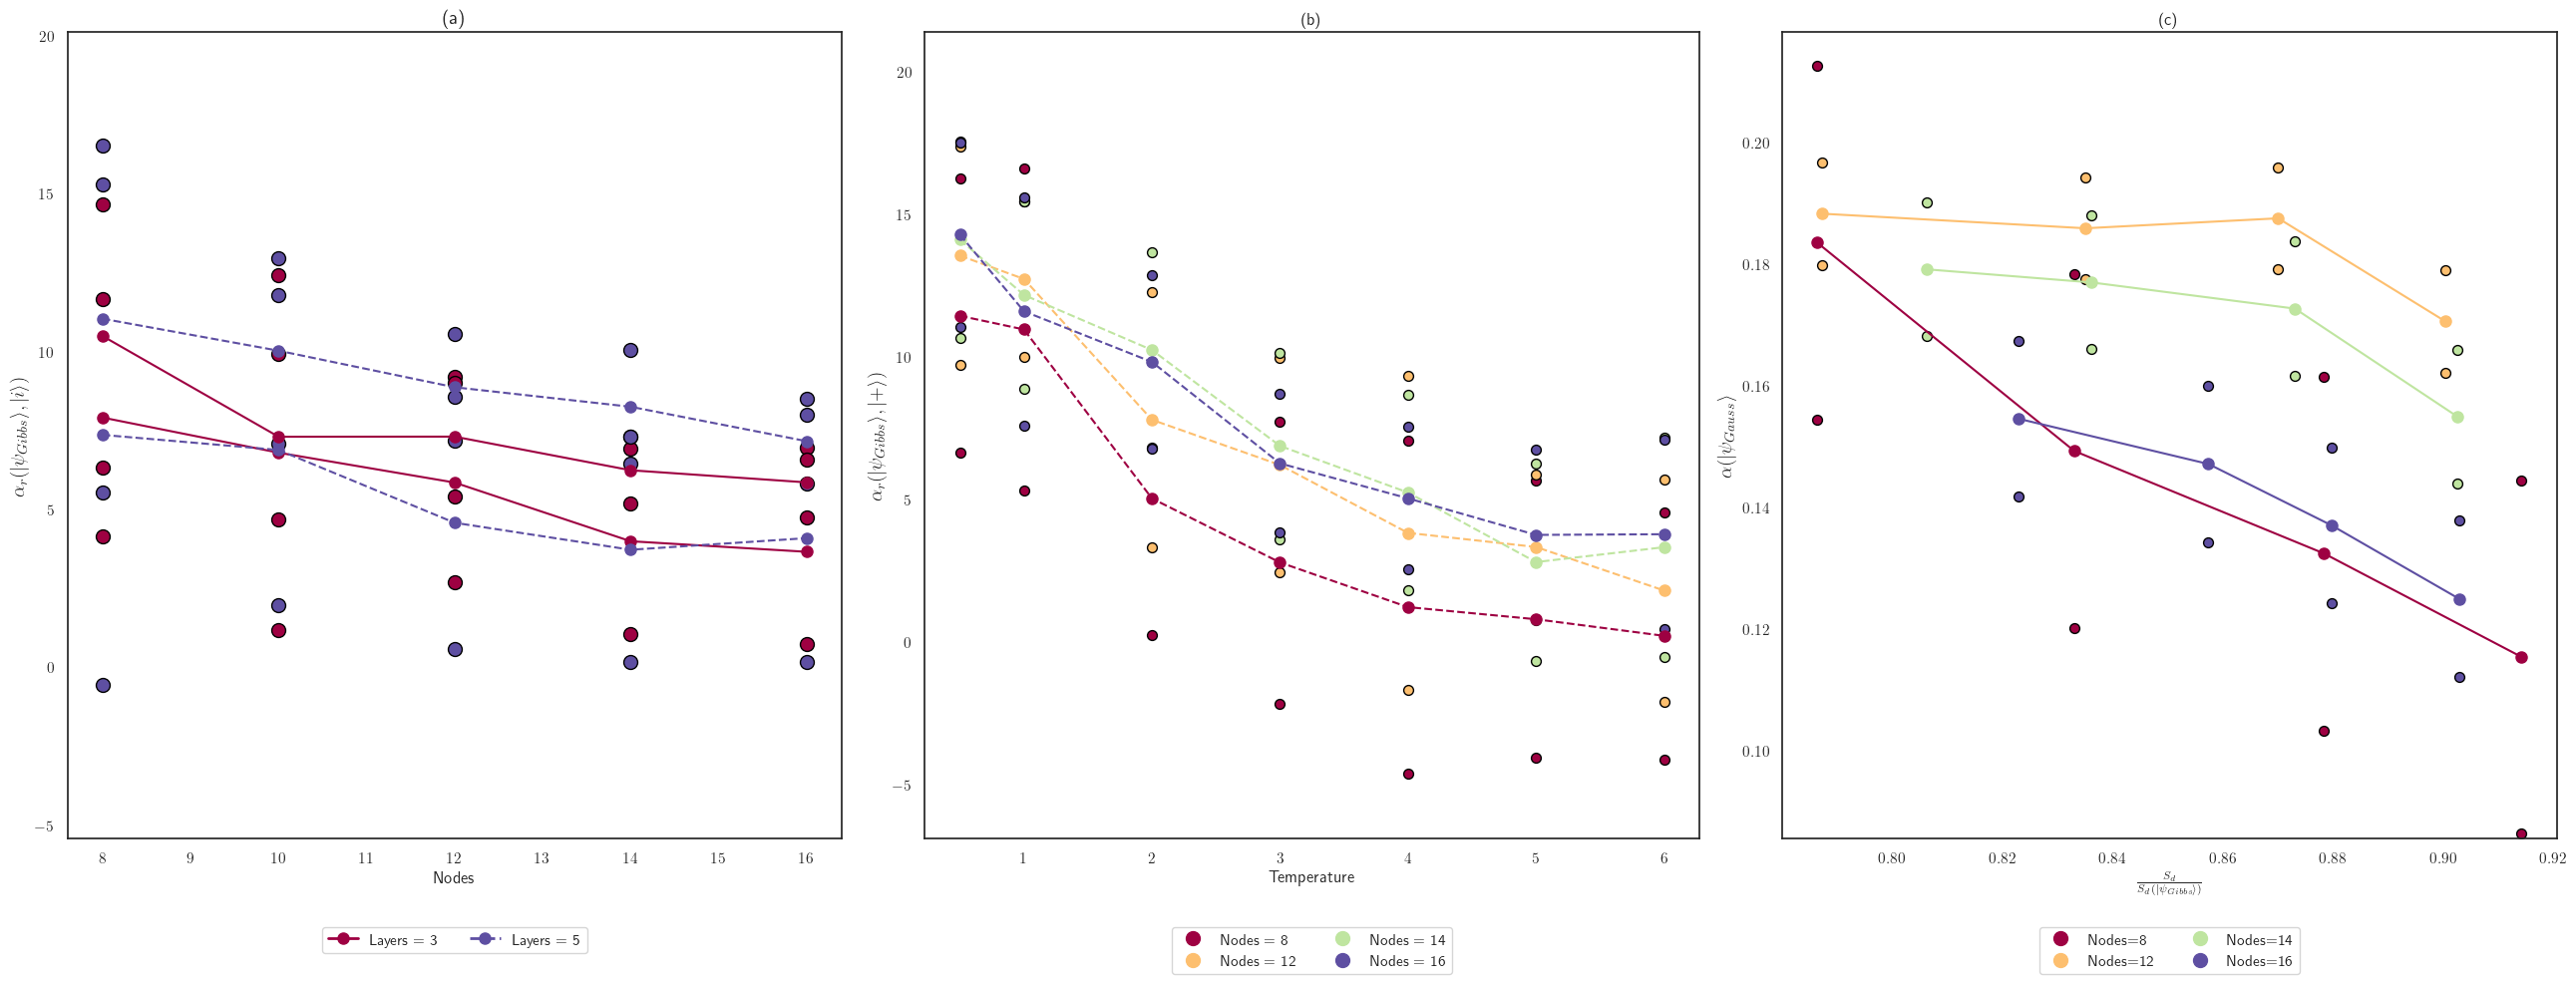

In [16]:
from matplotlib import rc

rc('text', usetex=True)
rc('font', family='serif')

fig, axs = plt.subplots(1, 3, figsize=(26, 10))


# Función para calcular márgenes
def add_margin_to_limits(limits, margin_factor=0.05):
    """Agregar margen a los límites de los ejes"""
    lower, upper = limits
    margin = (upper - lower) * margin_factor
    return lower - margin, upper + margin

# Primer gráfico (a)
summary_df = df_one_state.groupby(['nodes', 'temperature', 'layers']).agg(
    mean_energy_qaoa_difference=('energy_qaoa_difference', 'mean'),
    std_energy_qaoa_difference=('energy_qaoa_difference', 'std')
).reset_index()

# Define la paleta de colores usando la paleta Spectral
spectral = plt.get_cmap('Spectral')
color_map = {
    3: spectral(0),   
    5: spectral(1000)    
}

line_styles = {
    3: '-',   
    5: '--',  
}

markers = {
    3: 'o',   
    5: 'o',   
}

# Graficar los datos
for (temperature, layer) in summary_df[['temperature', 'layers']].drop_duplicates().values:
    subset = summary_df[(summary_df['temperature'] == temperature) & (summary_df['layers'] == layer)]
    subset = subset.sort_values(by='nodes')
    
    marker = markers.get(layer, 'o')  
    color = color_map.get(layer, 'k')  
    
    axs[0].plot(
        subset['nodes'],
        subset['mean_energy_qaoa_difference'],
        color=color,
        linestyle=line_styles.get(layer, '-'),
        marker=marker,
        markersize=8,
        label=f'Layers = {layer}'
    )
    
    axs[0].scatter(
        subset['nodes'],
        subset['mean_energy_qaoa_difference'] + subset['std_energy_qaoa_difference'],
        color=color,
        marker='o',
        edgecolor='black',
        s=100,
        label='_nolegend_'
    )
    
    axs[0].scatter(
        subset['nodes'],
        subset['mean_energy_qaoa_difference'] - subset['std_energy_qaoa_difference'],
        color=color,
        marker='o',
        edgecolor='black',
        s=100,
        label='_nolegend_'
    )

# Crear leyenda personalizada
line_legend_elements = [Line2D([0], [0], color=color_map[layer], linestyle=line_styles.get(layer, '-'), linewidth=2, marker=markers.get(layer, 'o'), markersize=8, label=f'Layers = {layer}') for layer in sorted(summary_df['layers'].unique())]
axs[0].legend(handles=line_legend_elements, bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2)

axs[0].set_xlabel('Nodes', fontdict={'family': 'serif', 'size': 12})
axs[0].set_ylabel(r'$\alpha_{r}(|\psi_{Gibbs} \rangle,  |i \rangle)$', fontdict={'family': 'serif', 'size': 14})
axs[0].set_title('(a)', fontdict={'family': 'serif', 'size': 14})



# Ajustar límites para el primer subplot
x_limits = [summary_df['nodes'].min(), summary_df['nodes'].max()]
y_limits = [summary_df['mean_energy_qaoa_difference'].min() - summary_df['std_energy_qaoa_difference'].max(), 
            summary_df['mean_energy_qaoa_difference'].max() + summary_df['std_energy_qaoa_difference'].max()]

axs[0].set_xlim(add_margin_to_limits(x_limits, margin_factor=0.05))
axs[0].set_ylim(add_margin_to_limits(y_limits, margin_factor=0.05))

# Segundo gráfico (b)
summary_df = (
    df_hadamard.groupby(["nodes", "temperature", "layers"])
    .agg(
        mean_energy_qaoa_difference=("energy_qaoa_difference", "mean"),
        std_energy_qaoa_difference=("energy_qaoa_difference", "std"),
    )
    .reset_index()
)

spectral = plt.get_cmap("Spectral", len(summary_df["nodes"].unique()))
color_map = {
    node: spectral(i / (len(summary_df["nodes"].unique()) - 1))
    for i, node in enumerate(sorted(summary_df["nodes"].unique()))
}

line_styles = {
    3: "-",  
    5: "--",  
}

markers = {
    3: "^",  
    5: "o",  
}

# Graficar los datos
for node, layer in summary_df[["nodes", "layers"]].drop_duplicates().values:

    subset = summary_df[(summary_df["nodes"] == node) & (summary_df["layers"] == layer)]
    subset = subset.sort_values(by="temperature")

    marker = markers.get(layer, "o")  

    axs[1].plot(
        subset["temperature"],
        subset["mean_energy_qaoa_difference"],
        color=color_map[node],
        linestyle=line_styles.get(layer, "-"),
        marker=marker,
        markersize=8,
        label=f"Nodes = {node}",
    )

    axs[1].scatter(
        subset["temperature"],
        subset["mean_energy_qaoa_difference"] + subset["std_energy_qaoa_difference"],
        color=color_map[node],
        marker=marker,
        edgecolor="black",
        s=50,
        label="_nolegend_",
    )

    axs[1].scatter(
        subset["temperature"],
        subset["mean_energy_qaoa_difference"] - subset["std_energy_qaoa_difference"],
        color=color_map[node],
        marker=marker,
        edgecolor="black",
        s=50,
        label="_nolegend_",
    )

color_legend_elements = [
    Line2D([0], [0], color=color_map[node], marker="o", linestyle="None", markersize=10, label=f"Nodes = {node}")
    for node in sorted(summary_df["nodes"].unique())
]

line_legend_elements = [
    Line2D([0], [0], color="black", linestyle=line_styles.get(layer, "-"), linewidth=2, label=f"Layers = {layer}")
    for layer in sorted(summary_df["layers"].unique())
]

axs[1].legend(
    handles=color_legend_elements , bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=2
)
axs[1].set_xlabel("Temperature", fontdict={'family': 'serif', 'size': 12})
axs[1].set_ylabel(r'$\alpha_{r}(|\psi_{Gibbs} \rangle,  |+ \rangle)$', fontdict={'family': 'serif', 'size': 14})
axs[1].set_title('(b)', fontdict={'family': 'serif', 'size': 12})

# Ajustar límites para el segundo subplot
x_limits = [summary_df['temperature'].min(), summary_df['temperature'].max()]
y_limits = [summary_df['mean_energy_qaoa_difference'].min() - summary_df['std_energy_qaoa_difference'].max(), 
            summary_df['mean_energy_qaoa_difference'].max() + summary_df['std_energy_qaoa_difference'].max()]

axs[1].set_xlim(add_margin_to_limits(x_limits, margin_factor=0.05))
axs[1].set_ylim(add_margin_to_limits(y_limits, margin_factor=0.05))

# Tercer gráfico (c)
sns.set(style="white")
nodes_list = sorted(df_results['nodes'].unique())
spectral = plt.get_cmap("Spectral", len(nodes_list))
color_map = {
    node: spectral(i / (len(nodes_list) - 1))
    for i, node in enumerate(nodes_list)
}

marker = "o"

# Iterar sobre cada tamaño de nodos para graficar las líneas con puntos de desviación estándar
for node in nodes_list:
    subset = df_results[df_results['nodes'] == node]
    
    x_means = subset['entropy_pseudo_gibbs_state']
    y_means = subset['energy_qaoa_pseudo_gibbs_state']
    y_std = subset['energy_qaoa_pseudo_gibbs_state'].std()
    
    axs[2].plot(
        x_means,
        y_means,
        marker=marker,
        linestyle="-",
        color=color_map[node],
        markersize=8,
        label=f'Nodes={node}'
    )

    axs[2].scatter(
        x_means,
        y_means + y_std,
        color=color_map[node],
        marker=marker,
        edgecolor="black",
        s=50,
        label="_nolegend_",
    )
    
    axs[2].scatter(
        x_means,
        y_means - y_std,
        color=color_map[node],
        marker=marker,
        edgecolor="black",
        s=50,
        label="_nolegend_",
    )

color_legend_elements = [
    Line2D([0], [0], color=color_map[node], marker="o", linestyle="None", markersize=10, label=f"Nodes={node}")
    for node in nodes_list
]

axs[2].legend(
    handles=color_legend_elements, bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=2
)
axs[2].set_xlabel(r'$\frac{S_{d}}{S_d(| \psi_{Gibbs} \rangle)}$', fontdict={'family': 'serif', 'size': 12})
axs[2].set_ylabel(r'$\alpha(|\psi_{Gauss} \rangle$', fontdict={'family': 'serif', 'size': 14})
axs[2].set_title('(c)', fontdict={'family': 'serif', 'size': 12})

# Ajustar límites para el tercer subplot
x_limits = [df_results['entropy_pseudo_gibbs_state'].min(), df_results['entropy_pseudo_gibbs_state'].max()]
y_limits = [df_results['energy_qaoa_pseudo_gibbs_state'].min() - df_results['energy_qaoa_pseudo_gibbs_state'].std(), 
            df_results['energy_qaoa_pseudo_gibbs_state'].max() + df_results['energy_qaoa_pseudo_gibbs_state'].std()]

axs[2].set_xlim(add_margin_to_limits(x_limits, margin_factor=0.05))
axs[2].set_ylim(add_margin_to_limits(y_limits, margin_factor=0.05))

# Ajustar espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()

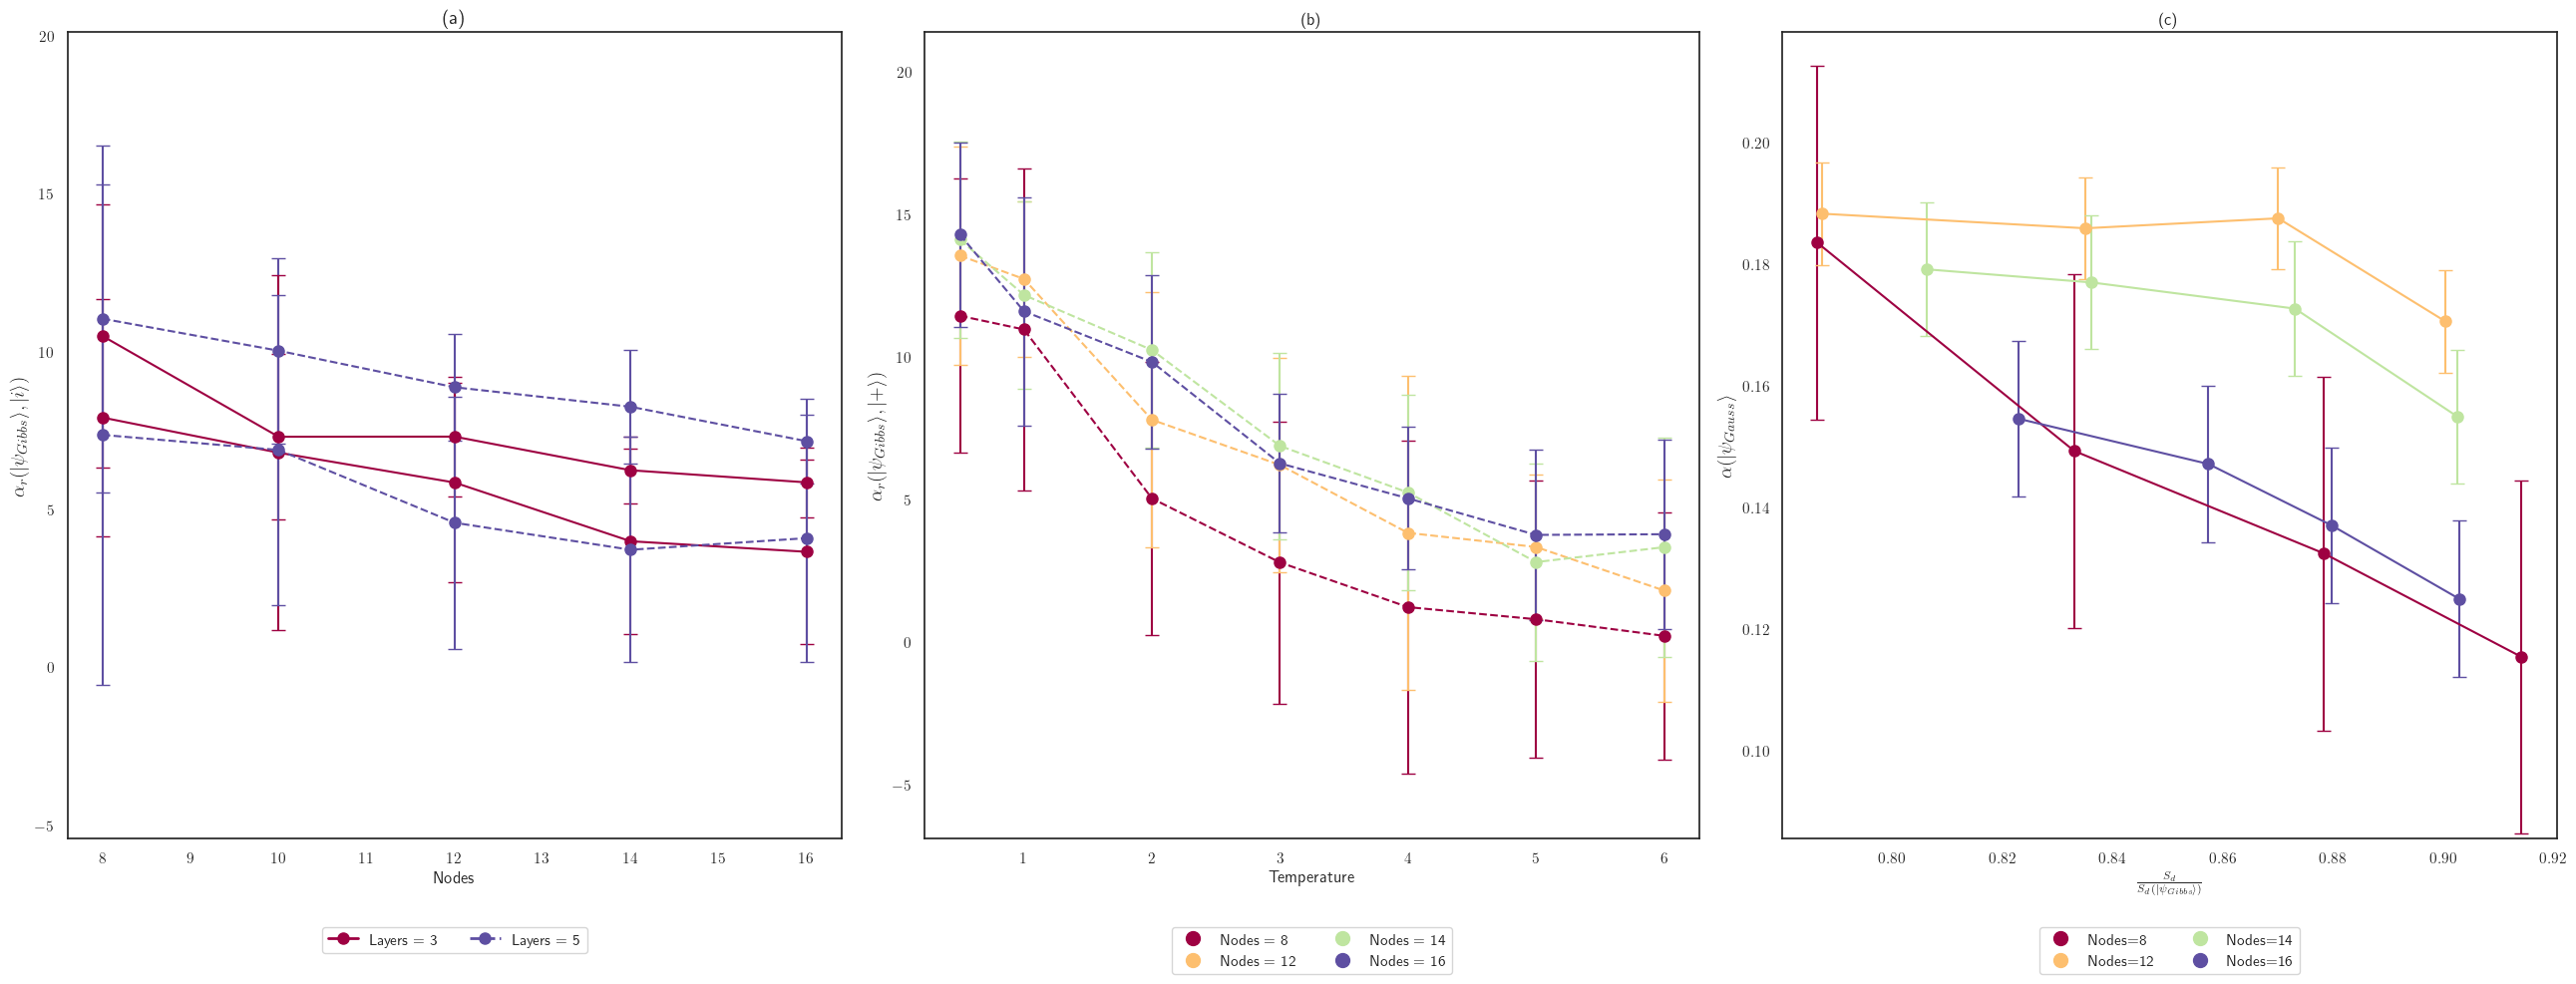

In [17]:
from matplotlib import rc
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D
import seaborn as sns

rc('text', usetex=True)
rc('font', family='serif')

fig, axs = plt.subplots(1, 3, figsize=(26, 10))

# Función para calcular márgenes
def add_margin_to_limits(limits, margin_factor=0.05):
    """Agregar margen a los límites de los ejes"""
    lower, upper = limits
    margin = (upper - lower) * margin_factor
    return lower - margin, upper + margin

# Primer gráfico (a)
summary_df = df_one_state.groupby(['nodes', 'temperature', 'layers']).agg(
    mean_energy_qaoa_difference=('energy_qaoa_difference', 'mean'),
    std_energy_qaoa_difference=('energy_qaoa_difference', 'std')
).reset_index()

# Define la paleta de colores usando la paleta Spectral
spectral = plt.get_cmap('Spectral')
color_map = {
    3: spectral(0),   
    5: spectral(1000)    
}

line_styles = {
    3: '-',   
    5: '--',  
}

markers = {
    3: 'o',   
    5: 'o',   
}

# Graficar los datos con barras de error
for (temperature, layer) in summary_df[['temperature', 'layers']].drop_duplicates().values:
    subset = summary_df[(summary_df['temperature'] == temperature) & (summary_df['layers'] == layer)]
    subset = subset.sort_values(by='nodes')
    
    marker = markers.get(layer, 'o')  
    color = color_map.get(layer, 'k')  
    
    # Usar errorbar en lugar de plot y scatter para las barras de error
    axs[0].errorbar(
        subset['nodes'],
        subset['mean_energy_qaoa_difference'],
        yerr=subset['std_energy_qaoa_difference'],
        color=color,
        linestyle=line_styles.get(layer, '-'),
        marker=marker,
        markersize=8,
        label=f'Layers = {layer}',
        capsize=5  # Añadir extremos a las barras de error
    )

# Crear leyenda personalizada
line_legend_elements = [Line2D([0], [0], color=color_map[layer], linestyle=line_styles.get(layer, '-'), linewidth=2, marker=markers.get(layer, 'o'), markersize=8, label=f'Layers = {layer}') for layer in sorted(summary_df['layers'].unique())]
axs[0].legend(handles=line_legend_elements, bbox_to_anchor=(0.5, -0.1), loc='upper center', ncol=2)

axs[0].set_xlabel('Nodes', fontdict={'family': 'serif', 'size': 12})
axs[0].set_ylabel(r'$\alpha_{r}(|\psi_{Gibbs} \rangle,  |i \rangle)$', fontdict={'family': 'serif', 'size': 14})
axs[0].set_title('(a)', fontdict={'family': 'serif', 'size': 14})

# Ajustar límites para el primer subplot
x_limits = [summary_df['nodes'].min(), summary_df['nodes'].max()]
y_limits = [summary_df['mean_energy_qaoa_difference'].min() - summary_df['std_energy_qaoa_difference'].max(), 
            summary_df['mean_energy_qaoa_difference'].max() + summary_df['std_energy_qaoa_difference'].max()]

axs[0].set_xlim(add_margin_to_limits(x_limits, margin_factor=0.05))
axs[0].set_ylim(add_margin_to_limits(y_limits, margin_factor=0.05))

# Repite el mismo patrón para los otros gráficos

# Segundo gráfico (b)
summary_df = (
    df_hadamard.groupby(["nodes", "temperature", "layers"])
    .agg(
        mean_energy_qaoa_difference=("energy_qaoa_difference", "mean"),
        std_energy_qaoa_difference=("energy_qaoa_difference", "std"),
    )
    .reset_index()
)

spectral = plt.get_cmap("Spectral", len(summary_df["nodes"].unique()))
color_map = {
    node: spectral(i / (len(summary_df["nodes"].unique()) - 1))
    for i, node in enumerate(sorted(summary_df["nodes"].unique()))
}

line_styles = {
    3: "-",  
    5: "--",  
}

markers = {
    3: "^",  
    5: "o",  
}

# Graficar los datos con barras de error
for node, layer in summary_df[["nodes", "layers"]].drop_duplicates().values:

    subset = summary_df[(summary_df["nodes"] == node) & (summary_df["layers"] == layer)]
    subset = subset.sort_values(by="temperature")

    marker = markers.get(layer, "o")  

    axs[1].errorbar(
        subset["temperature"],
        subset["mean_energy_qaoa_difference"],
        yerr=subset["std_energy_qaoa_difference"],
        color=color_map[node],
        linestyle=line_styles.get(layer, "-"),
        marker=marker,
        markersize=8,
        label=f"Nodes = {node}",
        capsize=5
    )

color_legend_elements = [
    Line2D([0], [0], color=color_map[node], marker="o", linestyle="None", markersize=10, label=f"Nodes = {node}")
    for node in sorted(summary_df["nodes"].unique())
]

line_legend_elements = [
    Line2D([0], [0], color="black", linestyle=line_styles.get(layer, "-"), linewidth=2, label=f"Layers = {layer}")
    for layer in sorted(summary_df["layers"].unique())
]

axs[1].legend(
    handles=color_legend_elements , bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=2
)
axs[1].set_xlabel("Temperature", fontdict={'family': 'serif', 'size': 12})
axs[1].set_ylabel(r'$\alpha_{r}(|\psi_{Gibbs} \rangle,  |+ \rangle)$', fontdict={'family': 'serif', 'size': 14})
axs[1].set_title('(b)', fontdict={'family': 'serif', 'size': 12})

# Ajustar límites para el segundo subplot
x_limits = [summary_df['temperature'].min(), summary_df['temperature'].max()]
y_limits = [summary_df['mean_energy_qaoa_difference'].min() - summary_df['std_energy_qaoa_difference'].max(), 
            summary_df['mean_energy_qaoa_difference'].max() + summary_df['std_energy_qaoa_difference'].max()]

axs[1].set_xlim(add_margin_to_limits(x_limits, margin_factor=0.05))
axs[1].set_ylim(add_margin_to_limits(y_limits, margin_factor=0.05))

# Tercer gráfico (c)
sns.set(style="white")
nodes_list = sorted(df_results['nodes'].unique())
spectral = plt.get_cmap("Spectral", len(nodes_list))
color_map = {
    node: spectral(i / (len(nodes_list) - 1))
    for i, node in enumerate(nodes_list)
}

marker = "o"

# Graficar los datos con barras de error
for node in nodes_list:
    subset = df_results[df_results['nodes'] == node]
    
    x_means = subset['entropy_pseudo_gibbs_state']
    y_means = subset['energy_qaoa_pseudo_gibbs_state']
    y_std = subset['energy_qaoa_pseudo_gibbs_state'].std()
    
    axs[2].errorbar(
        x_means,
        y_means,
        yerr=y_std,
        marker=marker,
        linestyle="-",
        color=color_map[node],
        markersize=8,
        label=f'Nodes={node}',
        capsize=5
    )

color_legend_elements = [
    Line2D([0], [0], color=color_map[node], marker="o", linestyle="None", markersize=10, label=f"Nodes={node}")
    for node in nodes_list
]

axs[2].legend(
    handles=color_legend_elements, bbox_to_anchor=(0.5, -0.1), loc="upper center", ncol=2
)
axs[2].set_xlabel(r'$\frac{S_{d}}{S_d(| \psi_{Gibbs} \rangle)}$', fontdict={'family': 'serif', 'size': 12})
axs[2].set_ylabel(r'$\alpha(|\psi_{Gauss} \rangle$', fontdict={'family': 'serif', 'size': 14})
axs[2].set_title('(c)', fontdict={'family': 'serif', 'size': 12})

# Ajustar límites para el tercer subplot
x_limits = [df_results['entropy_pseudo_gibbs_state'].min(), df_results['entropy_pseudo_gibbs_state'].max()]
y_limits = [df_results['energy_qaoa_pseudo_gibbs_state'].min() - df_results['energy_qaoa_pseudo_gibbs_state'].std(), 
            df_results['energy_qaoa_pseudo_gibbs_state'].max() + df_results['energy_qaoa_pseudo_gibbs_state'].std()]

axs[2].set_xlim(add_margin_to_limits(x_limits, margin_factor=0.05))
axs[2].set_ylim(add_margin_to_limits(y_limits, margin_factor=0.05))

# Ajustar espacio entre subplots
plt.tight_layout()

# Mostrar la figura
plt.show()


# **Heat Map**

In [24]:
tempeatures = list(np.arange(0.1, 2.4, 0.1))
i = 4

ruta_json = f'logger_data/logger_data_qaoa_performance_gibbs_states_heat_map/case_{i}_heat_map_n_6_3_layers_temperature_{tempeatures[0].round(1)}.json'

df_final = pd.read_json(ruta_json)

for z in tempeatures[1:]: 

    ruta_json = f'logger_data/logger_data_qaoa_performance_gibbs_states_heat_map/case_{i}_heat_map_n_6_3_layers_temperature_{z.round(1)}.json'

    df_l = pd.read_json(ruta_json)
    
    df_final = pd.concat([df_final, df_l], ignore_index=True)
    
path = f"logger_data/logger_data_qaoa_performance_gibbs_states_heat_map/case_{i}_heat_map_n_6_layers_3.json"

df_final.to_json(path, orient="records")

In [19]:
ruta_json = f'logger_data/logger_data_qaoa_performance_gibbs_states_heat_map/case_4_heat_map_n_6_layers_3.json'

df = pd.read_json(ruta_json)

In [20]:
df_nuevo = pd.DataFrame()

df_nuevo['energy']= pd.concat([df['energy_pseudo_gibbs_state'], 
                               df['energy_gibbs_state'], 
                               df['energy_one_state_final'],
                               df['energy_hadamard_state'],
                               df['energy_one_state'],
                               df['energy_random_state'],
                               ], 
                               axis=0, ignore_index=True)

df_nuevo['entropy']= pd.concat([df['entropy_pseudo_gibbs_state'], 
                                df['entropy_gibbs_state'],
                                df['entropy_one_state_final'],  
                                df['entropy_hadamard_state'],
                                df['entropy_one_state'],
                                df['entropy_random_state'],
                                ], 
                                axis=0, ignore_index=True)

df_nuevo['energy_QAOA']= pd.concat([df['energy_qaoa_pseudo_gibbs_state'], 
                                    df['energy_qaoa_gibbs_state'],
                                    df['energy_qaoa_one_state_final'], 
                                    df['energy_qaoa_hadamard_state'],
                                    df['energy_qaoa_one_state'],
                                    df['energy_qaoa_random_state'],
                                    ], 
                                    axis=0, ignore_index=True)

def find_closest_e_sol_g(row, df):
    closest_idx = (np.abs(df['energy_gibbs_state'] - row['energy'])).idxmin()
    return df.at[closest_idx, 'energy_qaoa_gibbs_state']

# Aplicar la función a cada fila de df1 y crear una nueva columna 'closest_e_sol_g'
df_nuevo['energy_ref'] = df_nuevo.apply(find_closest_e_sol_g, axis=1, df=df)

df_nuevo['relative_energy_final_gibbs'] = (abs(df_nuevo['energy_QAOA'].abs() - df_nuevo['energy_ref'].abs()))/df_nuevo['energy_ref'].abs()

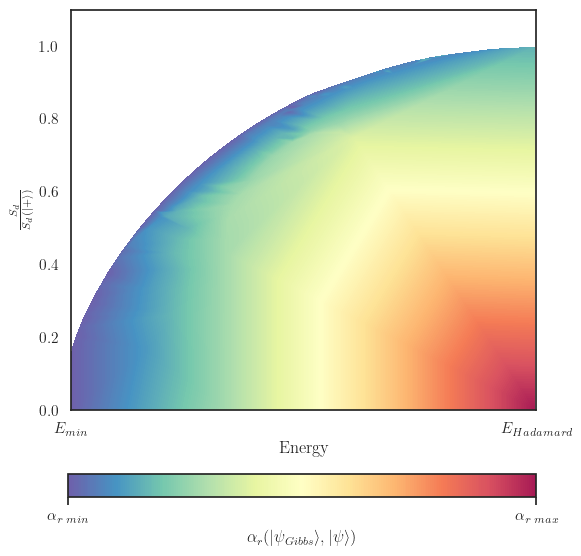

In [23]:
rc('text', usetex=True)
rc('font', family='serif')

plt.figure(figsize=(6, 8))

x_min, x_max = df_nuevo['energy'].min(), df_nuevo['energy'].max()
y_min, y_max = df_nuevo['entropy'].min(), df_nuevo['entropy'].max()

x_grid, y_grid = np.mgrid[x_min:x_max:10000j, y_min:y_max:10000j]

points = np.array(df_nuevo[['energy', 'entropy']])
values = np.array(df_nuevo['relative_energy_final_gibbs'])
z_grid = griddata(points, values, (x_grid, y_grid), method='linear')

# Normalizar los valores de z_grid para que vayan de 0 a 1
z_min, z_max = np.nanmin(z_grid), np.nanmax(z_grid)
z_grid_normalized = (z_grid - z_min) / (z_max - z_min)

# Revertir la paleta si es necesario
cmap = sns.color_palette("Spectral", as_cmap=True)
cmap = cmap.reversed()

# Aplicar el filtro gaussiano
sigma = 1
z_grid_smooth = gaussian_filter(z_grid_normalized, sigma=sigma)

# Mostrar la imagen normalizada
plt.imshow(z_grid_smooth.T, extent=(x_min, x_max, y_min, y_max), origin='lower', cmap=cmap, aspect='auto', alpha=0.9)

# Configurar la barra de colores para reflejar los valores reales
cbar = plt.colorbar(label=r'$\alpha_{r}(|\psi_{Gibbs} \rangle,  |\psi \rangle)$', orientation='horizontal', pad=0.2, aspect=20)
cbar.ax.set_position([0.12, 0.22, 0.78, 0.08]) 
cbar.set_ticks([0, 1])
cbar.set_ticklabels([r'$\alpha_{r \; min}$', r'$\alpha_{r \; max}$'])

# Configuración de los ejes
plt.ylim(0, 1.1)
plt.xticks([x_min, x_max], [r'$E_{min}$', r'$E_{Hadamard}$'])
plt.ylabel(r'$\frac{S_{d}}{S_{d}(| + \rangle)}$')
plt.xlabel('Energy')

plt.show()


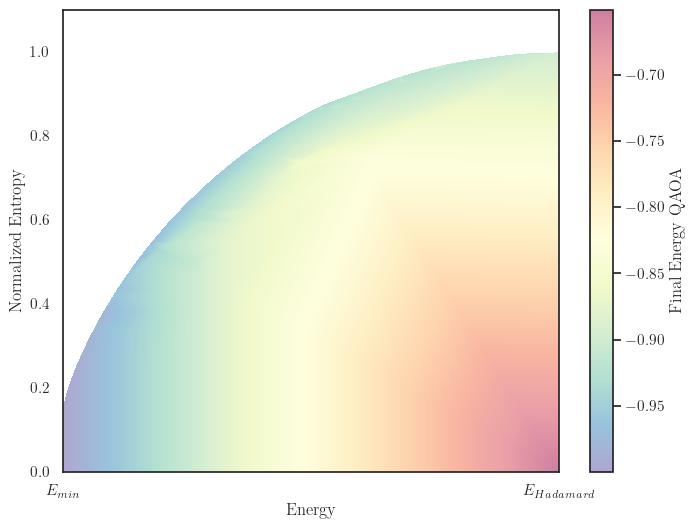

In [22]:
plt.figure(figsize=(8, 6))  

#palette = sns.color_palette("RdYlGn", as_cmap= True)

#sns.scatterplot(x='energy',  y='entropy', hue='relative_energy_final_gibbs', data=df_nuevo, s=20, legend=False, palette=palette)

x_min, x_max = df_nuevo['energy'].min(), df_nuevo['energy'].max()
y_min, y_max = df_nuevo['entropy'].min(), df_nuevo['entropy'].max()

	
x_grid, y_grid = np.mgrid[x_min:x_max:10000j, y_min:y_max:10000j]

# Interpolar los valores de z sobre la cuadrícula usando griddata

points = np.array(df_nuevo[['energy', 'entropy']])
values = np.array(df_nuevo['energy_QAOA'])
z_grid = griddata(points, values, (x_grid, y_grid), method='linear')

#cmap = sns.color_palette("coolwarm", as_cmap=True)
palette = sns.color_palette("RdYlGn", as_cmap= True)

sigma = 3
z_grid_smooth = gaussian_filter(z_grid, sigma=sigma)

plt.imshow(z_grid_smooth.T, extent=(x_min,x_max, y_min, y_max), origin='lower', cmap=cmap, aspect='auto', alpha=0.5)
plt.colorbar(label='Final Energy QAOA')
plt.ylim(0, 1.1)

plt.xticks([x_min, x_max], [r'$E_{min}$', r'$E_{Hadamard}$'])

plt.ylabel('Normalized Entropy')
plt.xlabel('Energy')

plt.show()